Подключение библиотек

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

Смотрим на данные

In [2]:
df = pd.read_csv("2015.csv")

In [3]:
df.head()

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


In [4]:
df.describe()

,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,79.493671,5.375734,0.047885,0.846137,0.991046,0.630259,0.428615,0.143422,0.237296,2.098977
std,45.754363,1.145010,0.017146,0.403121,0.272369,0.247078,0.150693,0.120034,0.126685,0.553550
min,1.000000,2.839000,0.018480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.328580
25%,40.250000,4.526000,0.037268,0.545808,0.856823,0.439185,0.328330,0.061675,0.150553,1.759410
50%,79.500000,5.232500,0.043940,0.910245,1.029510,0.696705,0.435515,0.107220,0.216130,2.095415
75%,118.750000,6.243750,0.052300,1.158448,1.214405,0.811013,0.549092,0.180255,0.309883,2.462415
max,158.000000,7.587000,0.136930,1.690420,1.402230,1.025250,0.669730,0.551910,0.795880,3.602140


Избавимся от ненужных столбцов.

In [5]:
df.Country.value_counts().sort_values()

Ecuador                1
France                 1
Afghanistan            1
Nigeria                1
Malaysia               1
Qatar                  1
Libya                  1
Bahrain                1
New Zealand            1
Russia                 1
Denmark                1
China                  1
Somaliland region      1
Dominican Republic     1
South Africa           1
Madagascar             1
Chad                   1
Haiti                  1
Colombia               1
Sudan                  1
Cyprus                 1
Mexico                 1
Switzerland            1
Zimbabwe               1
Lesotho                1
India                  1
Turkey                 1
Vietnam                1
Mauritius              1
Philippines            1
                      ..
Armenia                1
Estonia                1
Jordan                 1
Israel                 1
Bulgaria               1
Kenya                  1
Sierra Leone           1
Kosovo                 1
Congo (Kinshasa)       1


Видим, что каждая страна представлена 1 раз, поэтому это больше тянет на индекс, чем на признак, выбрасываем.

In [6]:
df.corr()

,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
Happiness Rank,1.000000,-0.992105,0.158516,-0.785267,-0.733644,-0.735613,-0.556886,-0.372315,-0.160142,-0.521999
Happiness Score,-0.992105,1.000000,-0.177254,0.780966,0.740605,0.724200,0.568211,0.395199,0.180319,0.530474
Standard Error,0.158516,-0.177254,1.000000,-0.217651,-0.120728,-0.310287,-0.129773,-0.178325,-0.088439,0.083981
Economy (GDP per Capita),-0.785267,0.780966,-0.217651,1.000000,0.645299,0.816478,0.370300,0.307885,-0.010465,0.040059
Family,-0.733644,0.740605,-0.120728,0.645299,1.000000,0.531104,0.441518,0.205605,0.087513,0.148117
Health (Life Expectancy),-0.735613,0.724200,-0.310287,0.816478,0.531104,1.000000,0.360477,0.248335,0.108335,0.018979
Freedom,-0.556886,0.568211,-0.129773,0.370300,0.441518,0.360477,1.000000,0.493524,0.373916,0.062783
Trust (Government Corruption),-0.372315,0.395199,-0.178325,0.307885,0.205605,0.248335,0.493524,1.000000,0.276123,-0.033105
Generosity,-0.160142,0.180319,-0.088439,-0.010465,0.087513,0.108335,0.373916,0.276123,1.000000,-0.101301
Dystopia Residual,-0.521999,0.530474,0.083981,0.040059,0.148117,0.018979,0.062783,-0.033105,-0.101301,1.000000


"Happiness Rank" сильно скореллировано с "Happiness Score".

In [7]:
dropped_happy = df.drop(["Standard Error", "Country", "Happiness Rank"], axis=1)
dropped_happy.head()

,Region,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Western Europe,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Western Europe,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Western Europe,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Western Europe,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,North America,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


In [8]:
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [9]:
data = []
for reg in df.Region.value_counts().index:
    data.append(
        go.Box(y=df[df.Region==reg]['Happiness Score'], name=reg)
    )

# визуализируем данные
iplot(data, show_link = False)

Видим, что регионы можно отранжировать по степени счастливости. Поэтому попробуем заменить регион медианным значением.

In [10]:
median = dropped_happy.groupby('Region')['Happiness Score'].median()
median

Region
Australia and New Zealand          7.285
Central and Eastern Europe         5.286
Eastern Asia                       5.729
Latin America and Caribbean        6.149
Middle East and Northern Africa    5.262
North America                      7.273
Southeastern Asia                  5.360
Southern Asia                      4.565
Sub-Saharan Africa                 4.272
Western Europe                     6.937
Name: Happiness Score, dtype: float64

In [11]:
dropped_happy.Region = dropped_happy.Region.map(median)

In [12]:
dropped_happy.head()

,Region,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,6.937,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,6.937,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,6.937,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,6.937,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,7.273,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


In [13]:
list(dropped_happy['Region'])

[6.937,
 6.937,
 6.937,
 6.937,
 7.273,
 6.937,
 6.937,
 6.937,
 7.285,
 7.285,
 5.2620000000000005,
 6.148999999999999,
 6.937,
 6.148999999999999,
 7.273,
 6.148999999999999,
 6.937,
 6.937,
 6.937,
 5.2620000000000005,
 6.937,
 5.2620000000000005,
 6.148999999999999,
 5.36,
 6.148999999999999,
 6.937,
 6.148999999999999,
 5.2620000000000005,
 6.937,
 6.148999999999999,
 5.2860000000000005,
 6.148999999999999,
 6.148999999999999,
 5.36,
 5.2620000000000005,
 6.937,
 6.937,
 5.729,
 5.2620000000000005,
 6.148999999999999,
 6.148999999999999,
 6.148999999999999,
 6.148999999999999,
 5.2860000000000005,
 5.2860000000000005,
 5.729,
 5.729,
 6.148999999999999,
 5.2620000000000005,
 6.937,
 6.148999999999999,
 5.2860000000000005,
 6.148999999999999,
 5.2860000000000005,
 5.2860000000000005,
 5.2860000000000005,
 6.148999999999999,
 6.148999999999999,
 5.2860000000000005,
 5.2860000000000005,
 5.36,
 5.2860000000000005,
 5.2620000000000005,
 5.2860000000000005,
 6.148999999999999,
 6.937,


Обучим несколько моделей и сравним результат.

In [14]:
X = dropped_happy.drop("Happiness Score", axis = 1)
y = dropped_happy['Happiness Score']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, test_size=0.3)

In [16]:
def evaluate(model):
    pred = model.predict(X_test)
    print("mse = ", mean_squared_error(y_test, pred))
    print("mae = ", mean_absolute_error(y_test, pred))
    print("r2  = ", r2_score(y_test, pred))

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)
evaluate(lr)

mse =  7.824708779446114e-08
mae =  0.0002331973261068173
r2  =  0.999999941219971


In [18]:
coef = zip(X.columns, lr.coef_)
coef_df = pd.DataFrame(list(zip(X.columns, lr.coef_)), columns=['features', 'coefficients'])
coef_df

,features,coefficients
0,Region,-0.000065
1,Economy (GDP per Capita),1.000084
2,Family,1.000048
3,Health (Life Expectancy),1.000121
4,Freedom,0.999803
5,Trust (Government Corruption),0.999985
6,Generosity,0.999994
7,Dystopia Residual,1.000022


In [19]:
tree = DecisionTreeRegressor()
param_grid = {'criterion': ['mse', 'mae'] , 'max_depth': [5, 10, 30, 100], 'min_samples_leaf': [1, 2, 5, 10]}
search = GridSearchCV(tree, n_jobs=-1, param_grid=param_grid, cv=5)
search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['mse', 'mae'],
                         'max_depth': [5, 10, 30, 100],
                         'min_samples_leaf': [1, 2, 5, 10]},
             pre_dispatch='2*n_jobs', refit

In [20]:
evaluate(search.best_estimator_)

mse =  0.2684362135416667
mae =  0.42611458333333346
r2  =  0.798347915056061


In [21]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
evaluate(rf)

mse =  0.12525464437499992
mae =  0.28086874999999983
r2  =  0.9059074040201739


In [22]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
evaluate(xgb)

mse =  0.08961095709448819
mae =  0.2373981233040491
r2  =  0.932683313873668


Вывод: видим, что лучше всего в этой задаче применить линейную регрессию.

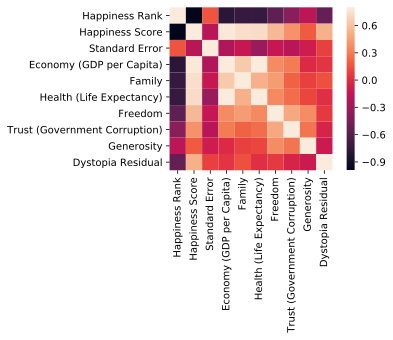

In [23]:
import seaborn as sns

f, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(df.corr(), vmax=.8, square=True);

Видим, что признаки довольно сильно скоррелированны и регуляризация может помочь.

In [24]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0, 0.005, 0.05, 0.1, 0.5, 1, 10]}
ridg = Lasso()
clf = GridSearchCV(ridg, param_grid=param_grid)
clf.fit(X, y)

pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005391,0.000216,0.003180,0.000025,0,{'alpha': 0},1.000000,0.999999,0.999999,0.999999,2.905850e-07,1
1,0.005244,0.000362,0.002966,0.000085,0.005,{'alpha': 0.005},0.735444,0.942543,0.939560,0.872091,9.709078e-02,2
2,0.004828,0.000073,0.002855,0.000030,0.05,{'alpha': 0.05},-2.162102,-0.134916,-1.263552,-1.186371,8.319683e-01,3
3,0.004817,0.000065,0.002838,0.000027,0.1,{'alpha': 0.1},-5.668595,-0.644793,-5.006229,-3.765402,2.233463e+00,4
4,0.004454,0.000420,0.002579,0.000246,0.5,{'alpha': 0.5},-13.792807,-1.175251,-14.965453,-9.946270,6.249813e+00,7
5,0.004786,0.000130,0.002839,0.000016,1,{'alpha': 1},-13.792807,-0.086411,-14.965453,-9.581026,6.762512e+00,5
6,0.004651,0.000327,0.002486,0.000181,10,{'alpha': 10},-13.792807,-0.105370,-14.965453,-9.587386,6.753583e+00,6


In [25]:
from sklearn.linear_model import Ridge

param_grid = {'alpha': [0, 0.005, 0.05, 0.1, 0.5, 1, 10]}
ridg = Ridge()
clf = GridSearchCV(ridg, param_grid=param_grid)
clf.fit(X, y)

pd.DataFrame(clf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006075,0.001373,0.003133,0.000559,0,{'alpha': 0},1.000000,0.999999,0.999999,0.999999,2.548111e-07,1
1,0.003826,0.000109,0.002334,0.000072,0.005,{'alpha': 0.005},0.999978,0.999993,0.999994,0.999989,7.342146e-06,2
2,0.003905,0.000146,0.002344,0.000119,0.05,{'alpha': 0.05},0.997987,0.999392,0.999433,0.998934,6.731548e-04,3
3,0.004449,0.000501,0.002428,0.000289,0.1,{'alpha': 0.1},0.992595,0.997691,0.997860,0.996037,2.446530e-03,4
4,0.003730,0.000006,0.002258,0.000050,0.5,{'alpha': 0.5},0.889700,0.959909,0.963658,0.937592,3.405942e-02,5
5,0.003770,0.000046,0.002255,0.000041,1,{'alpha': 1},0.715597,0.887787,0.893230,0.831818,8.260111e-02,6
6,0.003787,0.000028,0.002291,0.000041,10,{'alpha': 10},-1.550558,0.060484,-0.914048,-0.800661,6.645453e-01,7


Получили улучшение в третьем знаке после запятой, это того не стоило.